In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2

2025-06-08 06:58:31.817432: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 06:58:31.821550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-08 06:58:31.821563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# notebook parameters
n_dimensions = 1
step_size = 1e-1
n_pts = 10000
n_subsample = 1000

random_seed = 1

In [5]:
# network parameters
n_layers = 1
n_dim_per_layer = 2**5

#ACTIVATIONS = tf.nn.elu
def ACTIVATIONS(x):
    j = tf.constant(1j, dtype=tf.complex64)
    x = tf.cast(x, dtype=tf.complex64)
    return tf.exp(j * x)
VALIDATION_SPLIT = .1
BATCH_SIZE = 512
LEARNING_RATE = 1e-3
N_EPOCHS = 25

diffusivity_type = "diagonal"

In [6]:
# generate training data
def true_drift(x, param=None):
    return -0.5*x


def true_diffusion(x, param=None):
    return 0*(x*x)*0.01+np.sqrt(.01)


def true_drift_diffusion(x, param=None):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-1, 1]])

step_sizes = np.zeros((n_pts, 1)) + step_size

In [7]:
# train model
No_of_tests = 10
cumulative_times = np.zeros((No_of_tests, N_EPOCHS))
losses = np.zeros((No_of_tests, N_EPOCHS))
val_losses = np.zeros((No_of_tests, N_EPOCHS))
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed+i)
    tf.random.set_seed(random_seed+i)

    # generate data
    x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)

    # build network
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax())
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()

    # train network
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    cumulative_times[i,:] = timing_callback.epoch_times
    losses[i,:] = hist.history["loss"]
    val_losses[i,:] = hist.history["val_loss"]

    moving_avg = np.zeros(N_EPOCHS)
    min_moving_avg = float('inf')
    moving_avg_len = 5
    min_index = 0
    break_iterations = 5
    for j in range(N_EPOCHS):
        if j < moving_avg_len:
            moving_avg[j] = np.mean(val_losses[i,:j+1])
        else:
            moving_avg[j] = np.mean(val_losses[i,j-moving_avg_len+1:j+1])

        if moving_avg[j] < min_moving_avg:
            min_moving_avg = moving_avg[j]
            min_index = j

        if min_index + break_iterations < j:
            break

    val_loss_array = val_losses[i,:j]
    val_loss_min_index = np.argmin(val_loss_array)
    training_time[i] = cumulative_times[i,val_loss_min_index]
    val_loss[i] = val_losses[i,val_loss_min_index]


2025-06-08 06:58:38.218519: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-08 06:58:38.218552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: KW61146
2025-06-08 06:58:38.218558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: KW61146
2025-06-08 06:58:38.218675: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 560.35.3
2025-06-08 06:58:38.218697: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 560.35.3
2025-06-08 06:58:38.218702: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 560.35.3
2025-06-08 06:58:38.219146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

training for 25 epochs with 9000 data points, validating with 1000
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000
training for 25 epochs with 9000 data points, validating with 1000


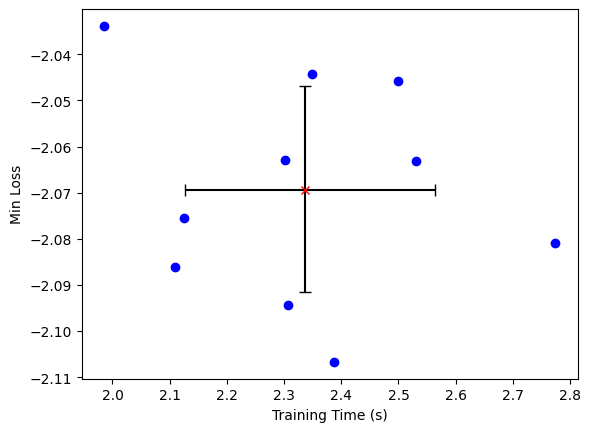

Mean Min Loss:  -2.069349691568589
Mean Training Time:  2.3369665861129763


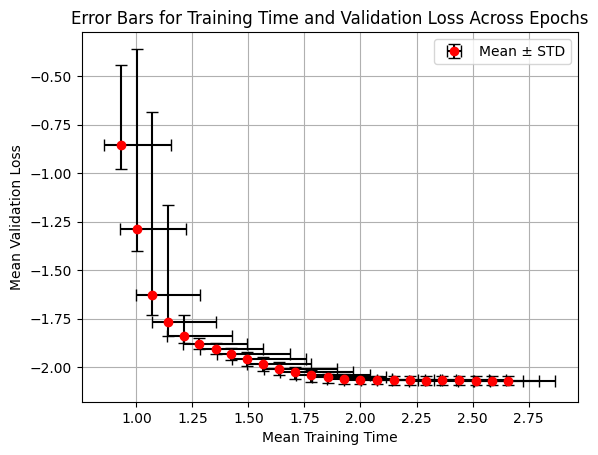

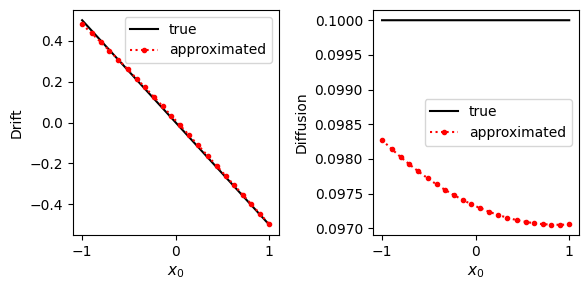

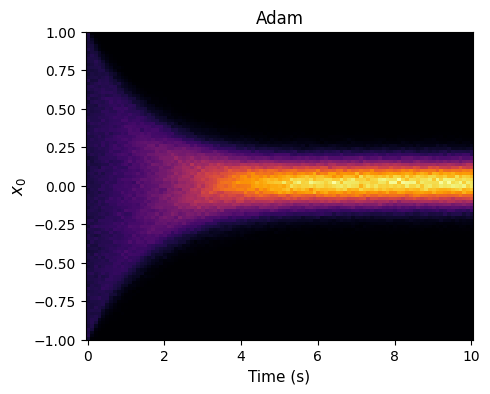

In [9]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=True)
    
PR.loss_v_time(cumulative_times, val_losses, save=True)

PR.plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusion, x_data, save=True)

time = 100*step_size
PR.plot_histogram(sde_i.drift_diffusivity, step_size, time, rng, xlim, name='Adam', save=True)


In [6]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 25)           50          ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 25)           50          ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_mean (Dense)         (None, 1)            26          ['GP_mean_hidden_0[0][0]']       
                                                                                